In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from pandas.core import common as com
import jsm

def set_span(start=None, end=None, periods=None, freq='D'):
    """ 引数のstart, end, periodsに対して
    startとendの時間を返す。

    * start, end, periods合わせて2つの引数が指定されていなければエラー
    * start, endが指定されていたらそのまま返す
    * start, periodsが指定されていたら、endを計算する
    * end, periodsが指定されていたら、startを計算する
    """
    if com._count_not_none(start, end, periods) != 2:  # Like a pd.date_range Error
        raise ValueError('Must specify two of start, end, or periods')
    start = start if start else (pd.Period(end, freq) - periods).start_time
    end = end if end else (pd.Period(start, freq) + periods).start_time
    return start, end


def get_jstock(code, freq='D', start=None, end=None, periods=None):
    """get Japanese stock data using jsm
    Usage:
        `get_jstock(6502)`
        To get TOSHIBA daily from today back to 30days except holiday.

        `get_jstock(6502, 'W', start=pd.Timestamp('2016'), end=pd.Timestamp('2017'))`
        To get TOSHIBA weekly from 2016-01-01 to 2017-01-01.

        `get_jstock(6502, end=pd.Timestamp('20170201'), periods=50)`
        To get TOSHIBA daily from 2017-02-01 back to 50days except holiday.

        `get_jstock(6502, 'M', start='first', end='last')`
        To get TOSHIBA monthly from 2000-01-01 (the date of start recording) to today.
    """
    # Default args
    if com._count_not_none(start, end, periods) == 0:  # All of args is None
        end, periods = 'last', 30

    # Switch frequency Dayly, Weekly or Monthly
    freq_dict = {'D': jsm.DAILY, 'W': jsm.WEEKLY, 'M': jsm.MONTHLY}

    # 'first' means the start of recording date
    if start == 'first':
        data = jsm.Quotes().get_historical_prices(
            code, range_type=freq_dict[freq], all=True)
        start = [i.date for i in data][-1]
    else:
        data = None  # Temporaly defined

    # 'last' means last weekday (or today)
    if end == 'last':
        end = pd.datetime.today()

    # Return "start" and "end"
    start, end = (x.date() if hasattr(x, 'date')
                  else x for x in set_span(start, end, periods, freq))
    print('Get data from {} to {}'.format(start, end))

    data = jsm.Quotes().get_historical_prices(
        code, range_type=freq_dict[freq], start_date=start, end_date=end) if not data else data
    df = _convert_dataframe(data)
    return df[start:end]


def _convert_dataframe(target):
    """Convert <jsm.pricebase.PriceData> to <pandas.DataFrame>"""
    date = [_.date for _ in target]
    open = [_.open for _ in target]
    high = [_.high for _ in target]
    low = [_.low for _ in target]
    close = [_.close for _ in target]
    adj_close = [_._adj_close for _ in target]
    volume = [_.volume for _ in target]
    data = {'Open': open,
            'High': high,
            'Low': low,
            'Close': close,
            'Adj Close': adj_close,
            'Volume': volume}
    columns = *data.keys(),
    df = pd.DataFrame(data, index=date, columns=columns).sort_index()
    df.index.name = 'Date'
    return df

In [3]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
#Chainerライブラリ
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions
import chainer.cuda
#正規化の際に必要となるsklearnライブラリ
from sklearn.preprocessing import MinMaxScaler

In [181]:
start = dt.date(2011,1,1)
end = dt.date(2019,1,20)
stock_num=5401
#7203：トヨタ、5411:JFE、6645:オムロン、5406:神鋼、5401:新日鉄
df_org = get_jstock(stock_num,start=pd.Timestamp(start),end=pd.Timestamp(end))
df_org = df_org.drop('Adj Close',axis=1)

#翌日のOpen値入力
df_add = df_org['Open'].shift(-1)
#最終日は当日のOpen値入力(これしないとNANになる)
df_add[len(df_org)-1] = df_add[len(df_org)-2] 

#翌日のOpen値入力
df_org = pd.concat([df_org,df_add], axis=1)

#翌日のClose値入力
df_add = df_org['Close'].shift(-1)
#最終日は当日のClose値入力(これしないとNANになる)
df_add[len(df_org)-1] = df_add[len(df_org)-2] 

#翌日のOpen値入力
df_org = pd.concat([df_org,df_add], axis=1)

#ｶﾗﾑ更新
df_org.columns = ['Open', 'High','Low', 'Close', 'Volume','Open-1','Close-1']

df_org.to_csv(str(stock_num)+".csv")
print("Finish")

Get data from 2011-01-01 to 2019-01-20


C:\Users\Owner\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Owner\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Finish


In [23]:
stock_num=5411
#7203：トヨタ、5411:JFE、6645:オムロン
df_org=pd.read_csv(str(stock_num)+"_diff.csv")

In [24]:
df_org.tail(10)


Date      Open      High       Low     Close     Volume    Open-1  \
1962   2019/1/4 -1.378119 -1.732752 -3.046221 -1.954085  17.317188  4.531146   
1963   2019/1/7  4.531146  4.400318  5.605671  4.149501   7.315542 -0.395816   
1964   2019/1/8 -0.395816 -0.743089 -1.084795 -0.502373  31.476843  2.517615   
1965   2019/1/9  2.517615  0.358473  2.242183  0.974531 -77.314310 -1.167004   
1966  2019/1/10 -1.167004 -0.248037 -0.506473 -0.388673  43.618147  1.635518   
1967  2019/1/11  1.635518  0.933816  1.539569  1.271438 -30.319328 -0.055006   
1968  2019/1/15 -0.055006  1.788181  0.802328  2.227143  -0.057068  2.579912   
1969  2019/1/16  2.579912  0.482187  0.027552 -1.898105   4.082656 -0.268457   
1970  2019/1/17 -0.268457  0.293529  1.204834  1.197293 -15.708376  0.803217   
1971  2019/1/18  0.803217 -0.053305  0.705183  1.022614 -11.015500  0.000000   

       Close-1  Close1hot1  Close1hot2  Close1hot3  Close1hot4  
1962  4.149501           0           0           0           1  
1963 -0.502373           0           1           0           0  
1964  0.974531           0           0           1           0  
1965 -0.388673           0           1           0           0  
1966  1.271438           0           0           0           1  
1967  2.227143           0           0           0           1  
1968 -1.898105           1           0           0           0  
1969  1.197293           0           0           0           1  
1970  1.022614           0           0           0           1  
1971  0.000000           0           0           1           0

In [25]:
test_open = np.array(df_org['Open'][len(df_org)-200:len(df_org)].reshape(-1,1)).astype(np.float32)
df_test_open = pd.DataFrame(test_open)

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [26]:
#スケーラの定義
t_scaler = MinMaxScaler(feature_range=(0, 1))
#スケーラフィッティング
df_x  = t_scaler.fit_transform(np.array(df_org['Close']).reshape(-1,1)).astype(np.float32)
df_x2 = t_scaler.fit_transform(np.array(df_org['Open']).reshape(-1,1)).astype(np.float32)
df_x3 = t_scaler.fit_transform(np.array(df_org['High']).reshape(-1,1)).astype(np.float32)
df_x4 = t_scaler.fit_transform(np.array(df_org['Low']).reshape(-1,1)).astype(np.float32)
df_x5 = t_scaler.fit_transform(np.array(df_org['Volume']).reshape(-1,1)).astype(np.float32)
df_x6 = t_scaler.fit_transform(np.array(df_org['Open-1']).reshape(-1,1)).astype(np.float32)
df_x7 = t_scaler.fit_transform(np.array(df_org['Close-1']).reshape(-1,1)).astype(np.float32)
df_t = t_scaler.fit_transform(np.array(df_org['Close']).reshape(-1,1)).astype(np.float32)
df_t1 = t_scaler.fit_transform(np.array(df_org['Close1hot1']).reshape(-1,1)).astype(np.float32)
df_t2 = t_scaler.fit_transform(np.array(df_org['Close1hot2']).reshape(-1,1)).astype(np.float32)
df_t3 = t_scaler.fit_transform(np.array(df_org['Close1hot3']).reshape(-1,1)).astype(np.float32)
df_t4 = t_scaler.fit_transform(np.array(df_org['Close1hot4']).reshape(-1,1)).astype(np.float32)

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [27]:
#株価データの整形
x,x2,x3,x4,x5,x6,x7,tt,t,t1,t2,t3,t4 = [],[],[],[],[],[],[],[],[],[],[],[],[]

N = len(df_org)
M = 1
for n in range(M,N):
    _x = df_x[n-M:n]
    _x2 = df_x2[n-M:n]
    _x3 = df_x3[n-M:n]
    _x4 = df_x4[n-M:n]
    _x5 = df_x5[n-M:n]
    _x6 = df_x6[n-M:n]
    _x7 = df_x7[n-M:n]
    _t = df_t[n]
    _t1 = df_t1[n]
    _t2 = df_t2[n]
    _t3 = df_t3[n]
    _t4 = df_t4[n]
    x.append(_x)
    x2.append(_x2)
    x3.append(_x3)
    x4.append(_x4)
    x5.append(_x5)
    x6.append(_x6)
    x7.append(_x7)
    t.append(_t)
    t1.append(_t1)
    t2.append(_t2)
    t3.append(_t3)
    t4.append(_t4)

In [28]:
#テストデータの個数
n_test = 200
#訓練データの個数
n_train = len(x)-n_test
#例：x[1]は初日からM日分の(標準化された)Closeﾃﾞｰﾀ、t[1]はM+1日目のCloseﾃﾞｰﾀ
x = np.array(x, dtype = np.float32)
x2 = np.array(x2, dtype = np.float32)
x3 = np.array(x3, dtype = np.float32)
x4 = np.array(x4, dtype = np.float32)
x5 = np.array(x5, dtype = np.float32)
x6 = np.array(x6, dtype = np.float32)
x7 = np.array(x7, dtype = np.float32)
t = np.array(t, dtype = np.float32).reshape(len(t),1)
t1 = np.array(t1, dtype = np.float32).reshape(len(t1),1)
t2 = np.array(t2, dtype = np.float32).reshape(len(t2),1)
t3 = np.array(t3, dtype = np.float32).reshape(len(t3),1)
t4 = np.array(t4, dtype = np.float32).reshape(len(t4),1)
# x = np.c_[x,x2,x3,x4,x5,x6]
# x = np.c_[x,x3,x4,x5,x6]
# x = np.c_[x,x6]
x = np.c_[x,x2,x3,x4,x5]
# x = x7

#t = np.c_[t1,t2,t3,t4]

#データの分割
dataset = list(zip(x, t))
train, test = chainer.datasets.split_dataset(dataset,n_train)

In [29]:
# ニューラルネットワークモデルを作成
class RNN(Chain):
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units)
            self.l2 = L.Linear(None, n_output)
    def reset_state(self):
        self.l1.reset_state()
    def __call__(self, x, t):
        y = self.predict(x)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss},self)
        return loss
    def predict(self, x):
        h1 = self.l1(x)
        return self.l2(h1)
## LSTMUpdaterを作る。
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater,self).__init__(data_iter, optimizer, device=None)
        self.device = device
    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")

        batch = data_iter.__next__()
        x_batch, t_batch = chainer.dataset.concat_examples(batch, self.device)
        
        optimizer.target.reset_state()           #追加
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, t_batch)
        loss.backward()
        loss.unchain_backward()                  #追記
        optimizer.update() 

In [52]:
# 乱数のシードを固定 (再現性の確保)
np.random.seed(1)

# モデルの宣言
model = RNN(30, 1)

# Optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

# Iterator
batchsize = 100 #ﾐﾆﾊﾞｯﾁのｻｲｽﾞ
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# Updater &lt;- LSTM用にカスタマイズ
updater = LSTMUpdater(train_iter, optimizer,device = -1)
#updater = chainer.training.StandardUpdater(train_iter, optimizer, device = -1)

# Trainerとそのextensions
epoch = 70
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')

# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model,device = -1))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
#trainer.extend(extensions.LogReport())

# １エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
#trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy','elapsed_time']), trigger=(1, 'epoch'))
trainer.extend(extensions.PrintReport(['epoch',
                                      'iteration',
                                      'elapsed_time',
                                      'main/loss',
                                      'validation/main/loss',
                                      'main/accuracy',
                                      'validation/main/accuracy']))


In [53]:
#5.training
trainer.run()

epoch       iteration   elapsed_time  main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           18          0.337934      0.460344    0.0677106                                                      
2           36          0.65238       0.0651198   0.0814599                                                      
3           54          0.960992      0.028145    0.0176607                                                      
4           71          1.2293        0.0171984   0.00635784                                                     
5           89          1.70453       0.0110168   0.00676282                                                     
6           107         2.0693        0.00987556  0.0061498                                                      
7           124         2.40745       0.0102162   0.00621577                                                     
8           142         2.82829       0.010115    0.00622084                              

In [54]:
train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

train_t = t_scaler.inverse_transform(train_t)




test_t = t_scaler.inverse_transform(test_t)
print(test_t)

[[ 0.67638266]
 [ 0.51898926]
 [ 0.57340366]
 [ 0.6319325 ]
 [ 0.57257682]
 [ 0.57903492]
 [ 0.58273727]
 [ 0.56229663]
 [ 0.59668338]
 [ 0.57157528]
 [ 0.7011084 ]
 [ 0.60799795]
 [ 0.5962227 ]
 [ 0.66521728]
 [ 0.54132372]
 [ 0.53817528]
 [ 0.58725029]
 [ 0.70110571]
 [ 0.58366364]
 [ 0.66887331]
 [ 0.64785385]
 [ 0.54831892]
 [ 0.56502295]
 [ 0.45592582]
 [ 0.70375025]
 [ 0.61924297]
 [ 0.63976687]
 [ 0.56783444]
 [ 0.51715958]
 [ 0.61073685]
 [ 0.61557424]
 [ 0.64507604]
 [ 0.64170331]
 [ 0.61599082]
 [ 0.62211072]
 [ 0.59321731]
 [ 0.5461126 ]
 [ 0.61166102]
 [ 0.44330397]
 [ 0.5254243 ]
 [ 0.55506349]
 [ 0.58788252]
 [ 0.52418566]
 [ 0.47869405]
 [ 0.58805686]
 [ 0.57927042]
 [ 0.67147392]
 [ 0.59225255]
 [ 0.57765329]
 [ 0.62299377]
 [ 0.53314722]
 [ 0.57762712]
 [ 0.60174561]
 [ 0.57334119]
 [ 0.54036111]
 [ 0.60104156]
 [ 0.48712602]
 [ 0.50922936]
 [ 0.49486101]
 [ 0.5762499 ]
 [ 0.58922523]
 [ 0.55204409]
 [ 0.57244319]
 [ 0.56112677]
 [ 0.55151492]
 [ 0.60827142]
 [ 0.50552

In [55]:
test_yy = []
model.reset_state()
test_yy = model.predict(Variable(test_x)).data
test_yy = t_scaler.inverse_transform(test_yy)

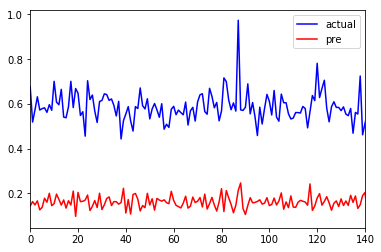

In [57]:
#★図表示
import matplotlib.pyplot as plt
plt.clf()
ax = plt.subplot()
plt.plot(test_t, label = 'actual', color='blue')  # 実測値
plt.plot(test_yy, label = 'pre', color='red')  # 実測値
ax.set_xlim([00,140])
plt.legend()
plt.show()
plt.savefig('C:\\Users\\Owner\\Desktop\\Django\\mySite\\static\\fig.png')

In [179]:
#正答率確認
updown_yy = []
updown_t = []
score = 0

#変動の計算()
# for i in range(len(test_yy)):
#     if test_yy[i]>0:
#         updown_yy.append(1)
#     if test_yy[i]<=0:
#         updown_yy.append(-1)
#     if test_t[i]>0:
#         updown_t.append(1)
#     if test_t[i]<=0:
#         updown_t.append(-1)

updown_yy.append(0)
updown_t.append(0)

for i in range(len(test_yy)):
    if i>0:
        if test_yy[i]>test_yy[i-1]:
            updown_yy.append(1)
        if test_yy[i]<=test_yy[i-1]:
            updown_yy.append(-1)
        if test_t[i]>test_t[i-1]:
            updown_t.append(1)
        if test_t[i]<=test_t[i-1]:
            updown_t.append(-1)

#正答率の計算
for i in range(len(updown_t)):
    if updown_yy[i] == updown_t[i]:
        score = score + 1

#正答率の表示
print((score-1)/(len(updown_t)-1)*100)

52.76381909547738


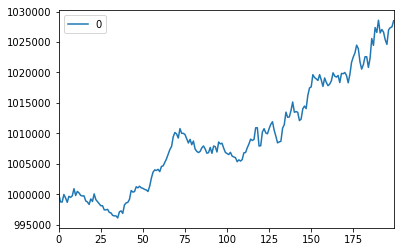

In [180]:
%matplotlib inline

#ファイル出力
df_updown_t = pd.DataFrame(updown_t)
df_updown_y = pd.DataFrame(updown_yy)
df_pre = pd.DataFrame(test_yy)
df_act = pd.DataFrame(test_t)

df_push = pd.concat([df_updown_y,df_updown_t,df_pre,df_act,df_test_open],axis=1)

df_push.to_csv("lstm6.csv")

#株購入SIM
balance = 1000000
balance_list = []
pay = 50000
back = []

for i in range(len(test_yy)):
    if i>0:
        if updown_yy[i]==1:
            balance = balance - pay
            st_num = pay/test_t[i-1]
            back.append(st_num*test_t[i])
            balance = balance + st_num*test_t[i]
            balance = float(balance)
        if updown_yy[i]==-1:
            balance = balance + pay
            st_num = pay/test_t[i-1]
            back.append(st_num*test_t[i])
            balance = balance - st_num*test_t[i]
            balance = float(balance)      
                
#         if updown_yy[i-1]==-11:
#             balance = balance + pay
#             st_num = pay/test_t[i-1]
#             if updown_t[i-1]==-1:
#                 balance = balance - st_num*test_t[i]        
    balance_list.append(balance)
    
df_bl = pd.DataFrame(balance_list)
df_push = pd.concat([df_push, df_bl], axis=1)
df_bl.plot()